## Problem to solve

We consider the following DPE :
$$
    \frac{\partial ²u}{\partial t²} = \frac{T}{\mu} \frac{\partial ²u}{\partial x²} 
$$
and its boundary conditions : 
$$
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \forall t > 0, \; u(x=0, t) = 0 \;\; (1)\\
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \forall t > 0, u(x=L, t) = 0 \;\; (2)\\
and \;\; for \;\; t=0, \;\;\; u(x, 0) = 2u_{max}sin(2\pi\frac{x}{\lambda}) \;\; (3)
$$
where $\lambda$ is the wave length and A is the maximum positive value reach by the string.  
  
To solve this equation, we'll use a PINN.
We define $f(t,x)$ as $f := \frac{\partial ²u}{\partial t²} - \frac{T}{\mu} \frac{\partial ²u}{\partial x²}, \;$ u the approximated function.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from math import pi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

In [2]:
class vanilla_PINN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, nof_hidden_layers):
        super().__init__()

        # To avoid bad entry: the inputs are x and t and the output is a scalar 
        try:

            if input_size != 2:
                raise ValueError("Input size must be equal to 2")

            elif output_size != 1:
                raise ValueError("Output size must be equal to 1")

            self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.GELU())
            self.output_layer = nn.Linear(hidden_size, output_size)

        except ValueError as error:
            print(error)
            return None

        # To be flexible on the number of hidden layers when instanciate the NN
        self.hidden_layers = nn.Sequential()

        for i in range(nof_hidden_layers):
            self.hidden_layers.add_module("hidden_layer_" + str(i), nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.add_module("GELU_" + str(i), nn.GELU())


    def forward(self, t, x):
        
        V = torch.cat([t, x], dim=1)
        V = self.input_layer(V)
        V = self.hidden_layers(V)
        V = self.output_layer(V)
        
        return V

## Utils

In [3]:
# Define Partial Derivative Equation (PDE) as a one of the loss
def f(t, x, neural_net, pb_params_list):
    """
        (from the problem) PDE : u_tt - (T / mu) * u_xx
        pb_params_list = [T, mu]
    """

    u    = neural_net(t, x)
    
    #d²u/dx² = u_xx 
    u_x  = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    
    # d²u/dt² = u_tt
    u_t  = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    PDE = u_tt - (pb_params_list[0] / pb_params_list[1]) * u_xx

    return PDE


# Loss function on boundary conditions points
def MSE_loss(groung_truth_pts, net_output_pts):
    mse_bc = nn.MSELoss()
    return mse_bc(groung_truth_pts, net_output_pts)


def train(model, nof_collocations_pts,
          x_bc1_pts, t_bc1_pts, u_bc1_pts,
          x_bc2_pts, t_bc2_pts, u_bc2_pts,
          x_bc3_pts, t_bc3_pts, u_bc3_pts,
          pb_params_list,
          optimizer, weight_loss1, weight_loss2, weight_loss3,
          nof_iterations, 
          device):

    training_loss = []

    for epoch in range(nof_iterations):

        model.train()
        optimizer.zero_grad()

        #Loss on first BC (u(x=0, t) = 0 for all t)
        x_bc1_pts = Variable(x_bc1_pts, requires_grad=False).to(device)
        t_bc1_pts = Variable(t_bc1_pts, requires_grad=False).to(device)
        u_bc1_pts = Variable(u_bc1_pts, requires_grad=False).to(device)

        net_output_bc1 = model(t_bc1_pts, x_bc1_pts)
        mse_u_bc1      = MSE_loss(u_bc1_pts, net_output_bc1)

        #Loss on second BC (u(x=L, t) = 0 for all t)
        x_bc2_pts = Variable(x_bc2_pts, requires_grad=False).to(device)
        t_bc2_pts = Variable(t_bc2_pts, requires_grad=False).to(device)
        u_bc2_pts = Variable(u_bc2_pts, requires_grad=False).to(device)

        net_output_bc2 = model(t_bc2_pts, x_bc2_pts)
        mse_u_bc2      = MSE_loss(u_bc2_pts, net_output_bc2)

        #Loss in third BC (u(x, t=0) = u_max * cos(2 * pi * x / lambda) for all x and where lambda is the wave length)
        #x_bc3_pts = Variable(x_bc3_pts, requires_grad=False).to(device)
        #t_bc3_pts = Variable(t_bc3_pts, requires_grad=False).to(device)
        #u_bc3_pts = Variable(u_bc3_pts, requires_grad=False).to(device)
        #
        #net_output_bc3 = model(t_bc3_pts, x_bc3_pts)
        #mse_u_bc3      = MSE_loss(u_bc3_pts, net_output_bc3)

        # PDE loss : collocations points form an equally spaced (t,x)-grid where x_max = L
        L     = x_bc2_pts.data[0].item()
        t_max = torch.max(t_bc1_pts).item()

        x_collocation_pts = torch.linspace(0, L, nof_collocations_pts)
        x_collocation_pts = x_collocation_pts.reshape(x_collocation_pts.shape[0], 1)
        x_collocation_pts = Variable(x_collocation_pts, requires_grad=True).to(device)

        t_collocation_pts = torch.linspace(0, t_max, nof_collocations_pts)
        t_collocation_pts = t_collocation_pts.reshape(t_collocation_pts.shape[0], 1)
        t_collocation_pts = Variable(t_collocation_pts, requires_grad=True).to(device)

        f_output = f(t_collocation_pts, x_collocation_pts, model, pb_params_list)
        mse_pde  = MSE_loss(f_output, torch.zeros_like(f_output))

        #Compute loss as the sum of all cost
        total_running_loss = weight_loss1 * mse_u_bc1 + weight_loss2 * mse_u_bc2 + weight_loss3 * mse_pde #+ mse_u_bc3 
        training_loss.append(total_running_loss.detach().to('cpu'))

        total_running_loss.backward()
        optimizer.step()

        with torch.autograd.no_grad():
            print('Epoch: {} | training loss: {:.12f}'.format(epoch, total_running_loss))

    return training_loss


## Main

Epoch: 0 | training loss: 2454.888916015625
Epoch: 1 | training loss: 2399.732421875000
Epoch: 2 | training loss: 2345.847167968750
Epoch: 3 | training loss: 2293.227539062500
Epoch: 4 | training loss: 2241.855957031250
Epoch: 5 | training loss: 2191.706542968750
Epoch: 6 | training loss: 2142.746582031250
Epoch: 7 | training loss: 2094.937744140625
Epoch: 8 | training loss: 2048.237304687500
Epoch: 9 | training loss: 2002.600097656250
Epoch: 10 | training loss: 1957.976562500000
Epoch: 11 | training loss: 1914.316162109375
Epoch: 12 | training loss: 1871.567871093750
Epoch: 13 | training loss: 1829.681274414062
Epoch: 14 | training loss: 1788.609741210938
Epoch: 15 | training loss: 1748.309326171875
Epoch: 16 | training loss: 1708.740478515625
Epoch: 17 | training loss: 1669.867431640625
Epoch: 18 | training loss: 1631.658081054688
Epoch: 19 | training loss: 1594.083129882812
Epoch: 20 | training loss: 1557.116821289062
Epoch: 21 | training loss: 1520.735839843750
Epoch: 22 | training

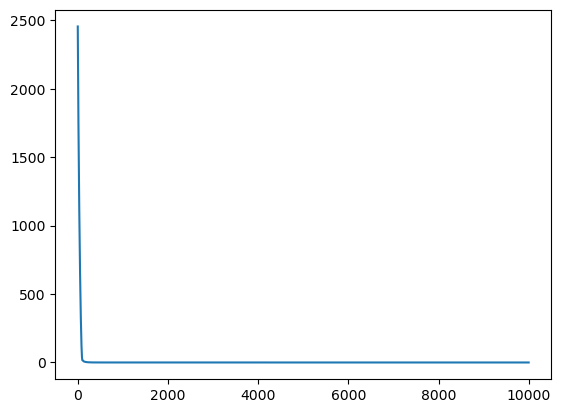

In [18]:
if __name__=="__main__":
    
    # Model
    input_size        = 2
    hidden_size       = 5
    output_size       = 1
    nof_hidden_layers = 5

    pinn = vanilla_PINN(input_size, hidden_size, output_size, nof_hidden_layers)
    pinn = pinn.to(device)
    
    # Problem params (nylon string)
    T     = 50        #Newton
    mu    = 8e-4      #kg/meter
    ro    = 950       #kg/m³ (volumic mass)
    d     = 1e-3      #meter (diameter of the string) 
    L     = 1e-1      #meter (length of the string)
    u_max = 1e-3      #meter
    t_max = 10        #seconds
    lbda  = 2 * L / 5 #meter (wave length at t=0)

    nof_pts = 10000

    # Setting first BC (u(x=0, t) = 0 for all t)
    x_bc1_pts = torch.zeros((nof_pts, 1))
    t_bc1_pts = torch.linspace(0, t_max, nof_pts)
    t_bc1_pts = t_bc1_pts.reshape(t_bc1_pts.shape[0], 1)
    u_bc1_pts = torch.zeros((nof_pts, 1))

    #Setting second BC (u(x=L, t) = 0 for all t)
    x_bc2_pts = L + torch.zeros((nof_pts, 1))
    t_bc2_pts = torch.linspace(0, t_max, nof_pts)
    t_bc2_pts = t_bc2_pts.reshape(t_bc2_pts.shape[0], 1)
    u_bc2_pts = torch.zeros((nof_pts, 1))

    #Setting third BC (u(x, t=0) = u_max * cos(2 * pi * x / lambda) for all x and where lambda is the wave length)
    x_bc3_pts = torch.linspace(0, L, nof_pts)
    x_bc3_pts = x_bc3_pts.reshape(x_bc3_pts.shape[0], 1)
    t_bc3_pts = torch.zeros((nof_pts, 1))
    u_bc3_pts = u_max * torch.cos(2 * pi * x_bc3_pts / lbda)
    u_bc3_pts = u_bc3_pts.reshape(u_bc3_pts.shape[0], 1)

    # Training
    model                = pinn
    pb_params_list       = [T, mu]
    nof_collocations_pts = 10000
    learning_rate        = 1e-3 #1e-3
    optimizer            = torch.optim.Adam(pinn.parameters(), lr=learning_rate)
    nof_iterations       = int(1e4) #1e4
    weight_loss1 = 10000
    weight_loss2 = 10000 #1e5
    weight_loss3 = 1

    training_loss = train(pinn, nof_collocations_pts,
                          x_bc1_pts, t_bc1_pts, u_bc1_pts,
                          x_bc2_pts, t_bc2_pts, u_bc2_pts,
                          x_bc3_pts, t_bc3_pts, u_bc3_pts,
                          pb_params_list,
                          optimizer, weight_loss1, weight_loss2, weight_loss3,
                          nof_iterations, 
                          device)

    #Plot training loss
    plt.plot(training_loss)
  
    #Save the model
    torch.save(pinn.state_dict(), 'pinn_model_stringvib.pt')

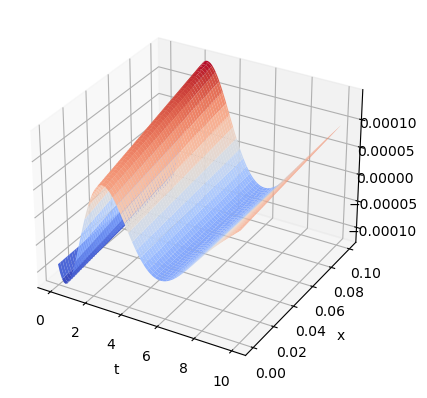

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Plot inference
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

nof_pts = 100

x_axis = np.linspace(0, L, nof_pts)
t_axis = np.linspace(0, t_max, nof_pts)
ms_t, ms_x = np.meshgrid(t_axis,x_axis, sparse=False)

pts_x = ms_x.reshape(-1, 1)
pts_t = ms_t.reshape(-1, 1)

pts_x = Variable(torch.from_numpy(pts_x).float(), requires_grad=True).to(device)
pts_t = Variable(torch.from_numpy(pts_t).float(), requires_grad=True).to(device)

pts_u = model(pts_t, pts_x)
ms_u = pts_u.to('cpu').detach().numpy()
ms_u = ms_u.reshape(ms_x.shape, order='C')

surface = ax.plot_surface(ms_t, ms_x, ms_u, 
                          cmap=cm.coolwarm, linewidth=0)#, antialiased=False)

plt.axis('auto')
ax.set_xlabel("t")
ax.set_ylabel("x")
plt.show()



 ## Interpretation

   After few trainings, we noted that the first and second boundary conditions aren't respected at all. We provide them higher weights than the one of the DPE cost. 
   With this changes, we notice better predictions of the overtones that start appearing on the curve: higher peak at $t=1s$ than the one at $t=2s$. The network tries to set all value to 0 on x=0.
   By a better setting of the hyper-parameters, we obtain the characteristics overtones. 

   Some ideas to enhance the PINN :
   - more neurons on the layers or more layers with the same amount of neurons
   - change the setting of the learning rate




   
